In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
''' Retrieves 10-year historical stock prices from Quandl given ticker symbol. 
    Optional start date argument may be used to define date range of interest.
'''
import os
#import json
import re
#import random as rnd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import requests as req
import numpy as np
import pandas as pd

import sqlalchemy as sa
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, exc
from sqlalchemy.sql import select, update, insert, table

from sqlalchemy.ext.declarative import declarative_base # extract classes into tables
from sqlalchemy import Column, Integer, String, Float, Date, MetaData 

import pymysql
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
# Create SQL database for cleaned data
Base = declarative_base() 

class historicalprice(Base):
    __tablename__= "historicalprice"
    symbol = Column(String(255), primary_key=True)
    date = Column(Date, primary_key=True)
    open = Column(Float)
    high = Column(Float)
    low = Column(Float)
    close = Column(Float)
    volume = Column(Float)
    ex_dividend = Column(Float)
    split_ratio = Column(Float)
    adj_open = Column(Float)
    adj_high = Column(Float)
    adj_low = Column(Float)
    adj_close = Column(Float)
    adj_volume = Column(Float)
    RMA_9 = Column(Float)
    RMA_21 = Column(Float)
    
class performancedata(Base):   
    __tablename__= "performancedata"
    BasicEPSNetIncome = Column(Float)
    CashandCashEquivalents = Column(Float)
    CommonStock = Column(Float)
    CostofRevenue = Column(Float)
    CurrentRatio = Column(Float)
    CurrentRatioFQ = Column(Float)
    CurrentRatioFY = Column(Float)
    DebttoEquity = Column(Float)
    DebttoEquityFQ = Column(Float)
    DebttoEquityFY = Column(Float)
    DilutedEPSNetIncome = Column(Float)
    EBIT = Column(Float)
    Goodwill = Column(Float)
    GrossMarginPctFQ = Column(Float)
    GrossMarginPctFY = Column(Float)
    GrossMarginPctTTM = Column(Float)
    GrossProfit= Column(Float)
    IntangibleAssets = Column(Float)
    MarketCapBasic = Column(Float)
    MarketCapTSO = Column(Float)
    NetIncome= Column(Float)
    OperatingMarginPctFQ = Column(Float)
    OperatingMarginPctFY = Column(Float)
    OperatingMarginPctTTM= Column(Float)
    OperatingProfit = Column(Float)
    PeriodEndDate = Column(Float)
    PriceBookFQ = Column(Float)
    PriceEarningsFY = Column(Float)
    PriceEarningsTTM = Column(Float)
    QuickRatioFQ = Column(Float)
    QuickRatioFY = Column(Float)
    TotalAssets = Column(Float)
    TotalCurrentAssets = Column(Float)
    TotalCurrentLiabilities = Column(Float)
    TotalLiabilities= Column(Float)
    TotalReceivablesNet = Column(Float)
    TotalRevenue = Column(Float)
    TotalStockholdersEquity = Column(Float)
    fiscalqtr =  Column(String(255), primary_key=True)
    fiscalyr =  Column(String(255))
    symbol =  Column(String(255), primary_key=True)
    
engine = create_engine('sqlite:///stockAI.sqlite')
Base.metadata.create_all(bind=engine)
Base.metadata.tables

immutabledict({'historicalprice': Table('historicalprice', MetaData(bind=None), Column('ticker', String(length=255), table=<historicalprice>, primary_key=True, nullable=False), Column('date', Date(), table=<historicalprice>), Column('open', Float(), table=<historicalprice>), Column('high', Float(), table=<historicalprice>), Column('low_close', Float(), table=<historicalprice>), Column('volume', Float(), table=<historicalprice>), Column('ex_dividend', Float(), table=<historicalprice>), Column('split_ratio', Float(), table=<historicalprice>), Column('adj_open', Float(), table=<historicalprice>), Column('adj_low', Float(), table=<historicalprice>), Column('adj_close', Float(), table=<historicalprice>), Column('adj_volume', Float(), table=<historicalprice>), schema=None), 'performancedata': Table('performancedata', MetaData(bind=None), Column('ticker', String(length=255), table=<performancedata>, primary_key=True, nullable=False), Column('date', Date(), table=<performancedata>), Column('Re

In [2]:
def urlhistprice_quandl(ticker, start_date=None):
    '''create url for historical price for quandl query
    '''
    try:
        assert start_date != None
    except AssertionError:
        #start_date = (datetime.now() + timedelta(-30)).date().isoformat()
        #if no start date is provided asumme 10 year financial history 
        start_date = (datetime.now() + relativedelta(years=-10)).date().isoformat()
    end_date = date.today().isoformat() #.strftime('%Y-%m-%d')
    report_range = 'start_date=' + start_date + '&end_date=' + end_date

    url = 'https://www.quandl.com/api/v3/datasets/WIKI/'+ticker+ \
            '.json?start_date=' + report_range
    return start_date, url

def getfinancials_quandl(ticker, start_date=None):
    '''gets historical price from quandl
    '''
    ticker = ticker.lower()
    try:
        assert start_date != None
    except AssertionError:
        #start_date = (datetime.now() + timedelta(-30)).date().isoformat()
        #if no start date is provided asumme 10 year financial history 
        start_date = (datetime.now() + relativedelta(years=-10)).date().isoformat()

    start_date, query_url = urlhistprice_quandl(ticker , start_date)
    #Retrieve historical prices
    res = req.get(query_url).json()
    column_names = ('Date,Open,High,Low,Close,Volume,Ex_Dividend,Split_Ratio,Adj_Open,'+ \
                                    'Adj_High,Adj_Low,Adj_Close,Adj_Volume').lower().split(',')
    df_histprice = pd.DataFrame(data=res['dataset']['data'], columns=column_names) #res['dataset']['column_names'])
    ##TODO:
        #Add ticker column if one sql table will be used for all tickers
        
    #connect to DB
    #_, Base , _ = connect_to_db()
    ###df_histprice.set_index('Date', inplace=True)
    #df_histprice.to_sql(ticker, engine, index=False, if_exists='replace',  \
                        #dtype={'date': Date})
    #conn.execute('CREATE INDEX idx_'+ticker+'_date ON '+db+'.'+ticker+' (date)')
    return df_histprice

def urlkeyratios(ticker):
    """ Build URL for required to get key ratio performance data for given ticker"""
    return 'http://financials.morningstar.com/ajax/exportKR2CSV.html?t='+ ticker

def getperformance(ticker):
    '''save performance data, use a boolan function for this process 
        determine curr5ent portfolio
        if new portfolio create a new directory
        save save performance data
    '''
    b_keyratios = req.get(urlkeyratios(ticker))
    str_keyratios = (b_keyratios.content.decode("utf-8-sig"))
    #write to file
    f = open(ticker+'_performance_key-ratios.txt', 'w')
    f.write(str_keyratios)
    f.close()

    fn = ticker+'_performance_key-ratios.txt'
    if not os.path.isfile(fn):
        print('{} does not exist' .format(fn))
        exit()
    dict_perf = {}
    pef_indx = 0
    #var_pef = ['fin', 'key_ratio', 'prof', 'growth', 'cash_flow', 'bal_sht', \
    #                                                            'liqu', 'eff']
    var_pef = ['financials', 'key_ratio', 'prof', 'growth', 'cash_flow', 'bal_sht', \
                                                                'liqu', 'eff']                                                                
    with open(fn, 'r') as f:
        lines = f.readlines()
        csv_ln = csv.reader(lines)
        pgstrt = [k for k in range(len(lines)) if lines[k][-4:].strip() =='TTM' or lines[k][-4:].strip() =='Qtr']
        pgbrk = [x-1 for x in range(len(lines)) if lines[x].strip()=='']
        pgbrk.append(len(lines)) 
        #pgstrt=2; pgbrk=17
        for ln in csv_ln:
            perf_key = var_pef[pef_indx]
        #loop thru perfromance characteristics and record dictionary
            if 'TTM' in ln or 'Latest Qtr' in ln:
                while csv_ln.line_num >= pgstrt[pef_indx]  and csv_ln.line_num <= pgbrk[pef_indx]:
                    #add all values of the current perf characteristics to the dict
                    if perf_key not in dict_perf.keys():
                        #add the performace variable to the dict
                        dict_perf['{}'.format(perf_key)] = []
                        dict_perf[perf_key].append(ln)
                        #print(dict_perf.keys())
                    else:
                        try:
                            dict_perf[perf_key].append(csv_ln.__next__())
                            #print(csv_ln.__next__(), csv_ln.line_num)
                        except StopIteration:
                            pgbrk[pef_indx] = pgbrk[pef_indx] - 1

                else:
                    #convert dict into np array
                    np_tmp = np.array(dict_perf[perf_key])
                    if dict_perf[perf_key][0][0] == '' and  perf_key == 'financials':
                        np_tmp[0][0] = 'Financial Categories'
                    elif dict_perf[perf_key][0][0] == '' and  len(dict_perf[perf_key][1]) == 1:
                        table_names = []
                        rows = []
                        for row in range(len(np_tmp)):
                            if len(np_tmp[row]) == 1:
                                table_names.append(np_tmp[row])
                                rows.append(row)
                        np_ttmp = np.delete(np_tmp, rows) 
                        np_tmp = np_ttmp
                    try:
                        #set index to first element from rows starting for row 1
                        index = list(np.reshape(np_tmp[:,0], np_tmp[:,0].size))
                        #set cols to all elements from row 0
                        cols = list(np.reshape(np_tmp[0,:], np_tmp[0,:].size))
                        #set data to all elements from row 1
                        data = np_tmp[1:,:]
                        dates = np.array(cols[1:]).reshape(len(cols[1:]),1)
                        data3 = data.T
                        data3 = np.char.replace(data3,u',', u'')
                        data3 = np.char.replace(data3,' ', '_')
                        tmp_ = np.insert(dates, 0, 'date', axis=0)
                        tmp_ = np.insert(tmp_, 1, ticker, axis=1)
                        tmp_[0][1]='symbol'
                        data3 = np.concatenate((tmp_,data3), axis=1)
                        data3[data3=='']=np.nan
                        df_finan = pd.DataFrame(data=data3[1:][:], columns=data3[0][:])
                        df_finan[df_finan=='nan']=np.nan
                        df_finan.iloc[:,2:].apply(pd.to_numeric)
                    except IndexError as growth:
                        pass
                    ticker = ticker.lower()
                    #df_finan.to_sql(perf_key, engine, index=False, if_exists='append')
                    print(df_finan)
                    pef_indx+=1
    f.close()
    return dict_perf
    #return df_finan


In [10]:
# define list of tickers
tickers =['MU', 'GIB', 'BIIB', 'UTHR', 'OZRK', 'BX', 'UFPO', 'TX', ]

# loop thru tickers and get historical price date
for ticker in tickers:
    getfinancials_quandl(ticker)

,date,open,high,low,close,volume,ex_dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,2018-03-27,173.680,175.150,166.9200,168.3400,38962839.0,0.0,1.0,173.680000,175.150000,166.920000,168.340000,38962839.0
1,2018-03-26,168.070,173.100,166.4400,172.7700,36272617.0,0.0,1.0,168.070000,173.100000,166.440000,172.770000,36272617.0
2,2018-03-23,168.390,169.920,164.9400,164.9400,40248954.0,0.0,1.0,168.390000,169.920000,164.940000,164.940000,40248954.0
3,2018-03-22,170.000,172.680,168.6000,168.8450,41051076.0,0.0,1.0,170.000000,172.680000,168.600000,168.845000,41051076.0
4,2018-03-21,175.040,175.090,171.2600,171.2700,35247358.0,0.0,1.0,175.040000,175.090000,171.260000,171.270000,35247358.0
5,2018-03-20,175.240,176.800,174.9400,175.2400,19314039.0,0.0,1.0,175.240000,176.800000,174.940000,175.240000,19314039.0
6,2018-03-19,177.320,177.470,173.6600,175.3000,32804695.0,0.0,1.0,177.320000,177.470000,173.660000,175.300000,32804695.0
7,2018-03-16,178.650,179.120,177.6200,178.0200,36836456.0,0.0,1.0,178.650000,179.120000,177.620000,178.020000,36836456.0
8,2018-03-15,178.500,180.240,178.0701,178.6500,22584565.0,0.0,1.0,178.500000,180.240000,178.070100,178.650000,22584565.0
9,2018-03-14,180.320,180.520,177.8100,178.4400,29075469.0,0.0,1.0,180.320000,180.520000,177.810000,178.440000,29075469.0


In [14]:
re=getperformance("goog")

       date symbol Revenue_USD_Mil Gross_Margin_% Operating_Income_USD_Mil  \
0   2008-12   goog           21796           60.4                     6632   
1   2009-12   goog           23651           62.6                     8312   
2   2010-12   goog           29321           64.5                    10381   
3   2011-12   goog           37905           65.2                    12242   
4   2012-12   goog           46039           62.7                    13834   
5   2013-12   goog           55519           60.4                    15403   
6   2014-12   goog           66001           61.1                    16496   
7   2015-12   goog           74989           62.4                    19360   
8   2016-12   goog           90272           61.1                    23716   
9   2017-12   goog          110855           58.9                    28882   
10      TTM   goog          110855           58.9                    28882   

   Operating_Margin_% Net_Income_USD_Mil Earnings_Per_Share_USD

In [111]:
df=getfinancials_quandl('VMC', start_date='2017-06-01')
df['date'] = pd.to_datetime(df['date']) #df['date'].astype(date)

In [112]:
df = df.set_index('date')

In [121]:
df['RMA_9'] = df.adj_close.rolling(9).mean().shift()
df['RMA_21'] = df.adj_close.rolling(21).mean()
df['hamming'] = df.adj_close.rolling(9, win_type='boxcar').mean()

In [124]:
df.describe()

,open,high,low,close,volume,ex_dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,MA_9,MA_21,hamming
count,206.000000,206.000000,206.000000,206.000000,2.060000e+02,206.000000,206.0,206.000000,206.000000,206.000000,206.000000,2.060000e+02,197.000000,186.000000,198.000000
mean,123.540340,124.867676,121.985172,123.438131,1.250870e+06,0.002427,1.0,123.320494,124.645860,121.767856,123.218483,1.250870e+06,123.300924,123.316693,123.321751
std,6.070645,6.217145,6.021464,6.129931,5.320787e+05,0.024573,0.0,6.080962,6.235190,6.026317,6.140229,5.320787e+05,5.714441,5.241142,5.707448
min,112.950000,113.990000,111.770000,112.570000,2.875890e+05,0.000000,1.0,112.720408,113.758294,111.542807,112.341181,2.875890e+05,114.120595,116.077995,114.120595
25%,119.152500,120.330000,117.460000,118.942500,9.448372e+05,0.000000,1.0,118.992633,120.050132,117.405209,118.712600,9.448372e+05,118.730000,118.482938,118.759205
50%,122.875000,124.215000,121.345000,122.725000,1.149124e+06,0.000000,1.0,122.658670,123.871017,121.116646,122.552657,1.149124e+06,122.879715,122.864200,122.890864
75%,127.275000,128.582500,125.625000,126.965000,1.439100e+06,0.000000,1.0,126.839386,128.419479,125.451401,126.592804,1.439100e+06,127.197859,127.015540,127.246965
max,141.000000,141.200000,138.545000,141.110000,4.817365e+06,0.250000,1.0,141.000000,141.200000,138.545000,141.110000,4.817365e+06,136.911111,135.193333,136.911111


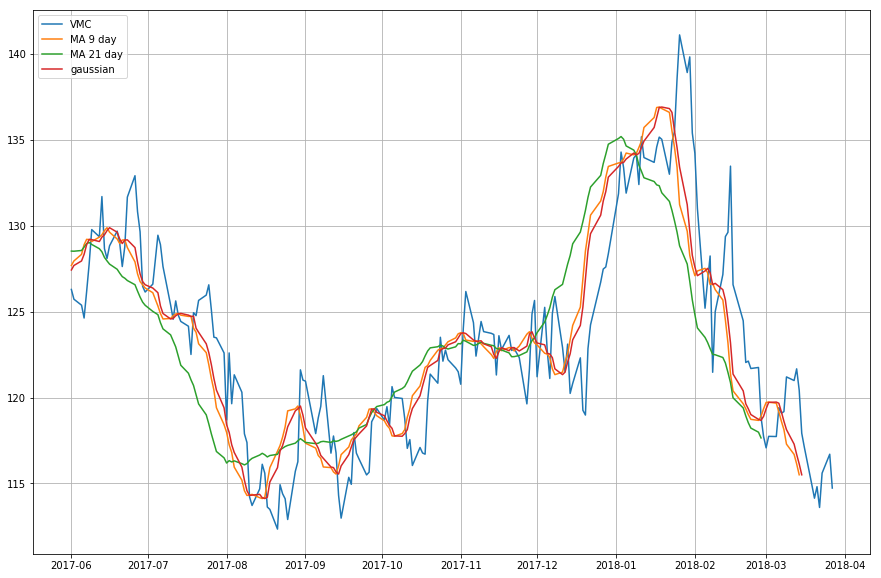

In [123]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['adj_close'],label='VMC')
plt.plot(df['MA_9'], label='MA 9 day')
plt.plot(df['MA_21'], label='MA 21 day')
plt.plot(df['hamming'], label='gaussian')
plt.legend(loc=2)

In [125]:
df['symbol'] = 'VMC'

In [126]:
df

,open,high,low,close,volume,ex_dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume,MA_9,MA_21,hamming,symbol
date,,,,,,,,,,,,,,,,
2018-03-27,116.70,117.2500,114.0600,114.73,1417198.0,0.0,1.0,116.700000,117.250000,114.060000,114.730000,1417198.0,NaN,NaN,NaN,VMC
2018-03-26,117.88,118.0700,114.8900,116.70,1611670.0,0.0,1.0,117.880000,118.070000,114.890000,116.700000,1611670.0,NaN,NaN,NaN,VMC
2018-03-23,114.27,117.3800,113.9750,115.60,1670337.0,0.0,1.0,114.270000,117.380000,113.975000,115.600000,1670337.0,NaN,NaN,NaN,VMC
2018-03-22,113.90,115.5650,113.5200,113.60,1331029.0,0.0,1.0,113.900000,115.565000,113.520000,113.600000,1331029.0,NaN,NaN,NaN,VMC
2018-03-21,114.55,116.3200,113.8400,114.81,987057.0,0.0,1.0,114.550000,116.320000,113.840000,114.810000,987057.0,NaN,NaN,NaN,VMC
2018-03-20,115.12,116.0000,112.9650,114.14,1112858.0,0.0,1.0,115.120000,116.000000,112.965000,114.140000,1112858.0,NaN,NaN,NaN,VMC
2018-03-19,116.40,116.5277,113.5900,114.90,1388638.0,0.0,1.0,116.400000,116.527700,113.590000,114.900000,1388638.0,NaN,NaN,NaN,VMC
2018-03-16,116.20,118.2600,115.6300,117.12,1843024.0,0.0,1.0,116.200000,118.260000,115.630000,117.120000,1843024.0,NaN,NaN,NaN,VMC
2018-03-15,120.52,120.9100,117.6400,117.92,1009354.0,0.0,1.0,120.520000,120.910000,117.640000,117.920000,1009354.0,NaN,NaN,115.502222,VMC


### Explore Raw Data

In [3]:
Base = declarative_base() 

In [4]:
engine = create_engine('sqlite:///stockAI.sqlite')

In [5]:
conn = engine.connect()

In [6]:
Base = automap_base()
Base.prepare(engine=engine, reflect=True)
session = Session(bind=engine)
Base.metadata.tables

immutabledict({'historicalprice': Table('historicalprice', MetaData(bind=None), Column('symbol', VARCHAR(length=255), table=<historicalprice>, primary_key=True, nullable=False), Column('date', DATE(), table=<historicalprice>, primary_key=True, nullable=False), Column('open', FLOAT(), table=<historicalprice>), Column('high', FLOAT(), table=<historicalprice>), Column('low', FLOAT(), table=<historicalprice>), Column('close', FLOAT(), table=<historicalprice>), Column('volume', FLOAT(), table=<historicalprice>), Column('ex_dividend', FLOAT(), table=<historicalprice>), Column('split_ratio', FLOAT(), table=<historicalprice>), Column('adj_open', FLOAT(), table=<historicalprice>), Column('adj_high', FLOAT(), table=<historicalprice>), Column('adj_low', FLOAT(), table=<historicalprice>), Column('adj_close', FLOAT(), table=<historicalprice>), Column('adj_volume', FLOAT(), table=<historicalprice>), Column('RMA_9', FLOAT(), table=<historicalprice>), Column('RMA_21', FLOAT(), table=<historicalprice>)

In [18]:
conn = engine.connect()
with conn:
    sql="Select date, low, close, adj_close FROM historicalprice WHERE symbol='mmm' ORDER BY date"
    df_his = pd.read_sql_query(sql, conn, index_col='date')
    
    sql="Select date, RMA_21, adj_close FROM historicalprice WHERE symbol='mmm' ORDER BY date"
    df = pd.read_sql_query(sql, conn, index_col='date')

In [37]:
df_his.head(50)

,low,close,adj_close
date,,,
2013-06-30 00:00:00.000000,109.140,109.35,98.443435
2013-09-30 00:00:00.000000,118.670,119.41,108.101907
2013-12-31 00:00:00.000000,139.480,140.25,127.592494
2014-03-31 00:00:00.000000,134.580,135.66,124.225704
2014-06-30 00:00:00.000000,143.060,143.24,131.964109
2014-09-30 00:00:00.000000,141.280,141.68,131.298700
2014-12-31 00:00:00.000000,164.200,164.32,153.099542
2015-03-31 00:00:00.000000,164.620,164.95,154.644260
2015-06-30 00:00:00.000000,154.070,154.30,145.575501


In [21]:
df_his.describe()

,low,close,adj_close
count,20.000000,20.000000,20.000000
mean,166.459250,167.268500,160.554301
std,34.911905,35.363601,39.369477
min,109.140000,109.350000,98.443435
25%,141.085000,141.747500,131.797756
50%,164.410000,164.635000,153.871901
75%,181.461250,181.760000,178.778617
max,237.860000,238.260000,238.260000


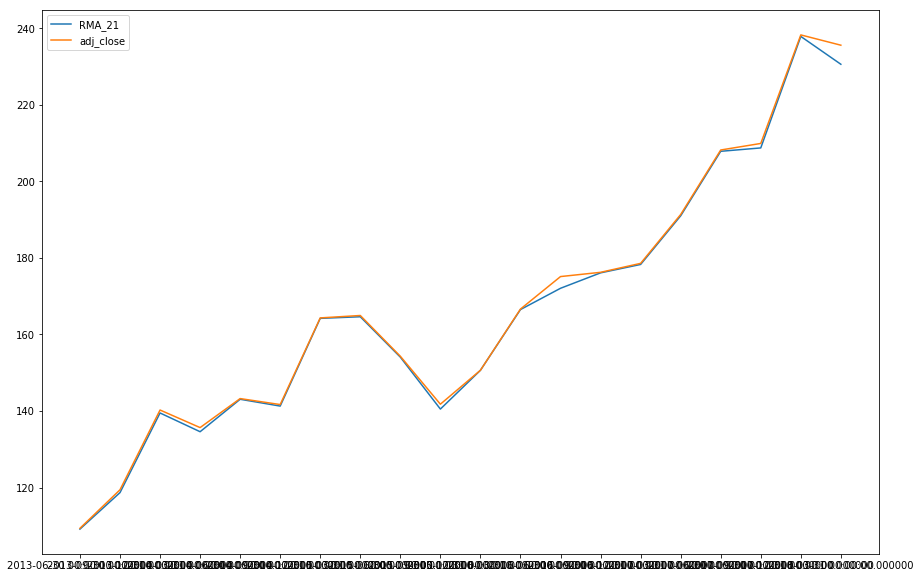

In [32]:
plt.figure(figsize=(15,10))
plt.plot(df_his.iloc[:400,0],label='RMA_21')
plt.plot(df_his.iloc[:400,1],label='adj_close')
plt.legend(loc=2)#.plot()#.scatter(0,1)

In [29]:
conn = engine.connect()
with conn:
    sql="Select date, fiscalqtr, BasicEPSNetIncome, DilutedEPSNetIncome, PriceBookFQ, TotalRevenue FROM performancedata WHERE symbol='MMM' ORDER BY date ASC"
    df_perf = pd.read_sql_query(sql, conn, index_col='date')

In [30]:
df_perf.describe()

,BasicEPSNetIncome,DilutedEPSNetIncome,PriceBookFQ,TotalRevenue
count,20.00000,20.00000,2.000000e+01,2.000000e+01
mean,1.93350,1.89400,1.153810e+01,7.736600e+09
std,0.35531,0.34561,5.467511e-15,2.471753e+08
min,0.88000,0.85000,1.153810e+01,7.298000e+09
25%,1.79250,1.76250,1.153810e+01,7.620000e+09
50%,1.93000,1.89500,1.153810e+01,7.710500e+09
75%,2.10750,2.05750,1.153810e+01,7.852250e+09
max,2.65000,2.58000,1.153810e+01,8.172000e+09


In [31]:
df_perf.head(50)

,fiscalqtr,BasicEPSNetIncome,DilutedEPSNetIncome,PriceBookFQ,TotalRevenue
date,,,,,
2013-03-31 00:00:00.000000,Q1,1.63,1.61,11.5381,7.634000e+09
2013-06-30 00:00:00.000000,Q2,1.74,1.71,11.5381,7.752000e+09
2013-09-30 00:00:00.000000,Q3,1.81,1.78,11.5381,7.916000e+09
2013-12-31 00:00:00.000000,Q4,1.65,1.62,11.5381,7.569000e+09
2014-03-31 00:00:00.000000,Q1,1.83,1.79,11.5381,7.831000e+09
2014-06-30 00:00:00.000000,Q2,1.94,1.91,11.5381,8.134000e+09
2014-09-30 00:00:00.000000,Q3,2.02,1.98,11.5381,8.137000e+09
2014-12-31 00:00:00.000000,Q4,1.85,1.82,11.5381,7.719000e+09
2015-03-31 00:00:00.000000,Q1,1.88,1.85,11.5381,7.578000e+09


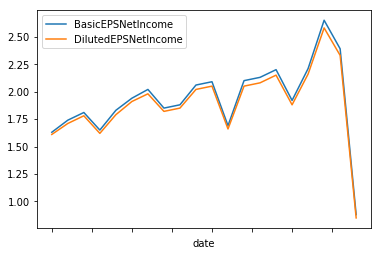

In [34]:
df_perf.iloc[:50,:3].plot()#.scatter(0,1)

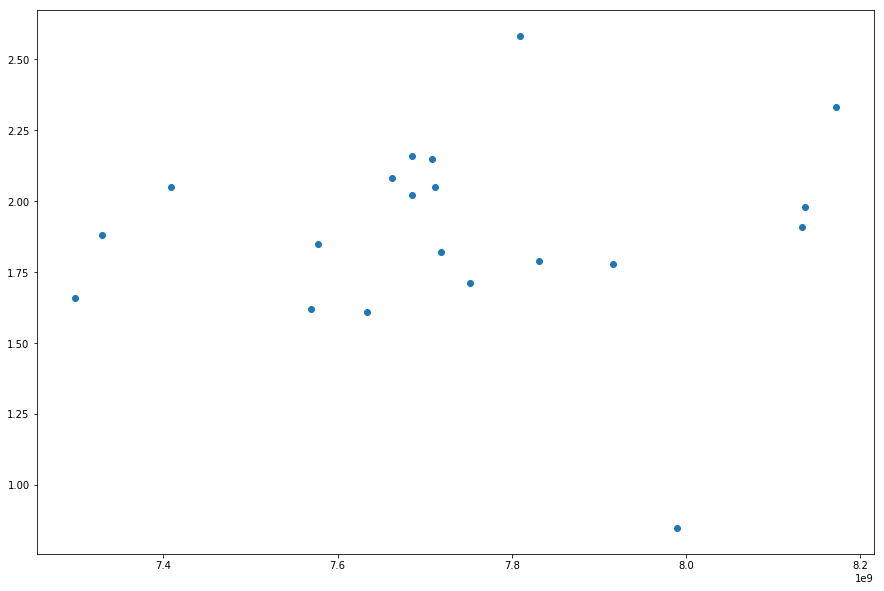

In [36]:
plt.figure(figsize=(15,10))
plt.scatter(df_perf['TotalRevenue'], df_perf['DilutedEPSNetIncome'])

### Data Preprocessing

In [213]:
conn = engine.connect()
with conn:
    sql="Select date, adj_open, adj_close, symbol FROM historicalprice ORDER BY date"
    df_target = pd.read_sql_query(sql, conn, index_col='date')
    
    sql="Select date, fiscalqtr, MarketCapBasic, TotalRevenue, CommonStock, NetIncome, TotalCurrentAssets, TotalCurrentLiabilities, TotalStockholdersEquity, symbol, EBIT, DebttoEquity, GrossMarginPctTTM, OperatingMarginPctTTM, BasicEPSNetIncome FROM performancedata ORDER BY date"
    df_features = pd.read_sql_query(sql, conn, index_col='date')

In [214]:
df_features['EPS']=df_features['CommonStock']/df_features['NetIncome']
#df_features['PEG']=df_features['PE']/(df_features['EPS_PY']/df_features['EPS_CY']-1)
df_features['PBV']=df_features['MarketCapBasic']/(df_features['TotalCurrentAssets']-df_features['TotalCurrentLiabilities'])
df_features['ROA']=df_features['NetIncome']/df_features['TotalStockholdersEquity']

In [215]:
df_features.where(df_features['symbol']=='GOOGL').dropna()

,fiscalqtr,MarketCapBasic,TotalRevenue,CommonStock,NetIncome,TotalCurrentAssets,TotalCurrentLiabilities,TotalStockholdersEquity,symbol,EBIT,DebttoEquity,GrossMarginPctTTM,OperatingMarginPctTTM,BasicEPSNetIncome,EPS,PBV,ROA
date,,,,,,,,,,,,,,,,,
2013-03-31 00:00:00.000000,Q1,7.428097e+11,1.295100e+10,2.342900e+10,3.346000e+09,6.280800e+10,1.325200e+10,7.547300e+10,GOOGL,3.748000e+09,0.06809,0.5888,0.2359,5.06,7.002092,14.989299,0.044334
2013-06-30 00:00:00.000000,Q2,7.428097e+11,1.310700e+10,2.433400e+10,3.228000e+09,6.686100e+10,1.532900e+10,7.885200e+10,GOOGL,3.465000e+09,0.06327,0.5888,0.2359,4.85,7.538414,14.414532,0.040937
2013-09-30 00:00:00.000000,Q3,7.428097e+11,1.375400e+10,2.500400e+10,2.970000e+09,6.885800e+10,1.447500e+10,8.298900e+10,GOOGL,3.761000e+09,0.06323,0.5888,0.2359,4.45,8.418855,13.658858,0.035788
2013-12-31 00:00:00.000000,Q4,7.428097e+11,1.570700e+10,2.592200e+10,3.189000e+09,7.288600e+10,1.590800e+10,8.730900e+10,GOOGL,4.429000e+09,0.06007,0.5888,0.2359,4.76,8.128567,13.036781,0.036525
2014-03-31 00:00:00.000000,Q1,7.428097e+11,1.542000e+10,2.665200e+10,3.452000e+09,7.531400e+10,1.627000e+10,9.171100e+10,GOOGL,4.115000e+09,0.06807,0.5888,0.2359,5.13,7.720742,12.580612,0.037640
2014-06-30 00:00:00.000000,Q2,7.428097e+11,1.595500e+10,2.711100e+10,3.351000e+09,7.790500e+10,1.709700e+10,9.574900e+10,GOOGL,4.258000e+09,0.05474,0.5888,0.2359,4.96,8.090421,12.215657,0.034998
2014-09-30 00:00:00.000000,Q3,7.428097e+11,1.652300e+10,2.794800e+10,2.739000e+09,8.011500e+10,1.792000e+10,9.881500e+10,GOOGL,3.724000e+09,0.05302,0.5888,0.2359,4.05,10.203724,11.943238,0.027718
2014-12-31 00:00:00.000000,Q4,7.428097e+11,1.810300e+10,2.876700e+10,4.675000e+09,7.865600e+10,1.677900e+10,1.038600e+11,GOOGL,4.399000e+09,0.05042,0.5888,0.2359,6.89,6.153369,12.004617,0.045013
2015-03-31 00:00:00.000000,Q1,7.428097e+11,1.725800e+10,2.952700e+10,3.515000e+09,8.031300e+10,1.433600e+10,1.084480e+11,GOOGL,4.447000e+09,0.04827,0.5888,0.2359,5.16,8.400284,11.258616,0.032412


In [216]:
#df_target['adj_closeRatio'] = df_target['adj_close']/df_target['adj_close'].shift(1)
df_target['symbol']= df_target['symbol'].str.upper()
df_target.where(df_target['symbol']=='GOOGL').dropna()

,adj_open,adj_close,symbol
date,,,
2013-06-30 00:00:00.000000,438.804548,441.548016,GOOGL
2013-09-30 00:00:00.000000,435.885537,439.311111,GOOGL
2013-12-31 00:00:00.000000,557.842005,562.090118,GOOGL
2014-03-31 00:00:00.000000,566.950121,558.980519,GOOGL
2014-06-30 00:00:00.000000,586.760000,584.670000,GOOGL
2014-09-30 00:00:00.000000,587.490000,588.410000,GOOGL
2014-12-31 00:00:00.000000,537.740000,530.660000,GOOGL
2015-03-31 00:00:00.000000,557.940000,554.700000,GOOGL
2015-06-30 00:00:00.000000,545.090000,540.040000,GOOGL


In [217]:
df_features_ = df_features.reset_index()
df_target_ = df_target.reset_index()
features = df_target_.merge(df_features_, on=['symbol', 'date']).dropna().set_index('date')

In [218]:
features.where(features['symbol']=='GOOGL').dropna()

,adj_open,adj_close,symbol,fiscalqtr,MarketCapBasic,TotalRevenue,CommonStock,NetIncome,TotalCurrentAssets,TotalCurrentLiabilities,TotalStockholdersEquity,EBIT,DebttoEquity,GrossMarginPctTTM,OperatingMarginPctTTM,BasicEPSNetIncome,EPS,PBV,ROA
date,,,,,,,,,,,,,,,,,,,
2013-06-30 00:00:00.000000,438.804548,441.548016,GOOGL,Q2,7.428097e+11,1.310700e+10,2.433400e+10,3.228000e+09,6.686100e+10,1.532900e+10,7.885200e+10,3.465000e+09,0.06327,0.5888,0.2359,4.85,7.538414,14.414532,0.040937
2013-09-30 00:00:00.000000,435.885537,439.311111,GOOGL,Q3,7.428097e+11,1.375400e+10,2.500400e+10,2.970000e+09,6.885800e+10,1.447500e+10,8.298900e+10,3.761000e+09,0.06323,0.5888,0.2359,4.45,8.418855,13.658858,0.035788
2013-12-31 00:00:00.000000,557.842005,562.090118,GOOGL,Q4,7.428097e+11,1.570700e+10,2.592200e+10,3.189000e+09,7.288600e+10,1.590800e+10,8.730900e+10,4.429000e+09,0.06007,0.5888,0.2359,4.76,8.128567,13.036781,0.036525
2014-03-31 00:00:00.000000,566.950121,558.980519,GOOGL,Q1,7.428097e+11,1.542000e+10,2.665200e+10,3.452000e+09,7.531400e+10,1.627000e+10,9.171100e+10,4.115000e+09,0.06807,0.5888,0.2359,5.13,7.720742,12.580612,0.037640
2014-06-30 00:00:00.000000,586.760000,584.670000,GOOGL,Q2,7.428097e+11,1.595500e+10,2.711100e+10,3.351000e+09,7.790500e+10,1.709700e+10,9.574900e+10,4.258000e+09,0.05474,0.5888,0.2359,4.96,8.090421,12.215657,0.034998
2014-09-30 00:00:00.000000,587.490000,588.410000,GOOGL,Q3,7.428097e+11,1.652300e+10,2.794800e+10,2.739000e+09,8.011500e+10,1.792000e+10,9.881500e+10,3.724000e+09,0.05302,0.5888,0.2359,4.05,10.203724,11.943238,0.027718
2014-12-31 00:00:00.000000,537.740000,530.660000,GOOGL,Q4,7.428097e+11,1.810300e+10,2.876700e+10,4.675000e+09,7.865600e+10,1.677900e+10,1.038600e+11,4.399000e+09,0.05042,0.5888,0.2359,6.89,6.153369,12.004617,0.045013
2015-03-31 00:00:00.000000,557.940000,554.700000,GOOGL,Q1,7.428097e+11,1.725800e+10,2.952700e+10,3.515000e+09,8.031300e+10,1.433600e+10,1.084480e+11,4.447000e+09,0.04827,0.5888,0.2359,5.16,8.400284,11.258616,0.032412
2015-06-30 00:00:00.000000,545.090000,540.040000,GOOGL,Q2,7.428097e+11,1.772700e+10,3.072200e+10,3.931000e+09,8.416400e+10,1.736200e+10,1.117830e+11,4.825000e+09,0.04681,0.5888,0.2359,4.99,7.815314,11.119572,0.035166


In [219]:
features['PE']=features['adj_close']/features['EPS']

In [220]:
features.where(features['symbol']=='GOOGL').dropna()

,adj_open,adj_close,symbol,fiscalqtr,MarketCapBasic,TotalRevenue,CommonStock,NetIncome,TotalCurrentAssets,TotalCurrentLiabilities,TotalStockholdersEquity,EBIT,DebttoEquity,GrossMarginPctTTM,OperatingMarginPctTTM,BasicEPSNetIncome,EPS,PBV,ROA,PE
date,,,,,,,,,,,,,,,,,,,,
2013-06-30 00:00:00.000000,438.804548,441.548016,GOOGL,Q2,7.428097e+11,1.310700e+10,2.433400e+10,3.228000e+09,6.686100e+10,1.532900e+10,7.885200e+10,3.465000e+09,0.06327,0.5888,0.2359,4.85,7.538414,14.414532,0.040937,58.573066
2013-09-30 00:00:00.000000,435.885537,439.311111,GOOGL,Q3,7.428097e+11,1.375400e+10,2.500400e+10,2.970000e+09,6.885800e+10,1.447500e+10,8.298900e+10,3.761000e+09,0.06323,0.5888,0.2359,4.45,8.418855,13.658858,0.035788,52.181811
2013-12-31 00:00:00.000000,557.842005,562.090118,GOOGL,Q4,7.428097e+11,1.570700e+10,2.592200e+10,3.189000e+09,7.288600e+10,1.590800e+10,8.730900e+10,4.429000e+09,0.06007,0.5888,0.2359,4.76,8.128567,13.036781,0.036525,69.149965
2014-03-31 00:00:00.000000,566.950121,558.980519,GOOGL,Q1,7.428097e+11,1.542000e+10,2.665200e+10,3.452000e+09,7.531400e+10,1.627000e+10,9.171100e+10,4.115000e+09,0.06807,0.5888,0.2359,5.13,7.720742,12.580612,0.037640,72.399848
2014-06-30 00:00:00.000000,586.760000,584.670000,GOOGL,Q2,7.428097e+11,1.595500e+10,2.711100e+10,3.351000e+09,7.790500e+10,1.709700e+10,9.574900e+10,4.258000e+09,0.05474,0.5888,0.2359,4.96,8.090421,12.215657,0.034998,72.266946
2014-09-30 00:00:00.000000,587.490000,588.410000,GOOGL,Q3,7.428097e+11,1.652300e+10,2.794800e+10,2.739000e+09,8.011500e+10,1.792000e+10,9.881500e+10,3.724000e+09,0.05302,0.5888,0.2359,4.05,10.203724,11.943238,0.027718,57.666201
2014-12-31 00:00:00.000000,537.740000,530.660000,GOOGL,Q4,7.428097e+11,1.810300e+10,2.876700e+10,4.675000e+09,7.865600e+10,1.677900e+10,1.038600e+11,4.399000e+09,0.05042,0.5888,0.2359,6.89,6.153369,12.004617,0.045013,86.238937
2015-03-31 00:00:00.000000,557.940000,554.700000,GOOGL,Q1,7.428097e+11,1.725800e+10,2.952700e+10,3.515000e+09,8.031300e+10,1.433600e+10,1.084480e+11,4.447000e+09,0.04827,0.5888,0.2359,5.16,8.400284,11.258616,0.032412,66.033478
2015-06-30 00:00:00.000000,545.090000,540.040000,GOOGL,Q2,7.428097e+11,1.772700e+10,3.072200e+10,3.931000e+09,8.416400e+10,1.736200e+10,1.117830e+11,4.825000e+09,0.04681,0.5888,0.2359,4.99,7.815314,11.119572,0.035166,69.100229


### Explore Preprocessed Data

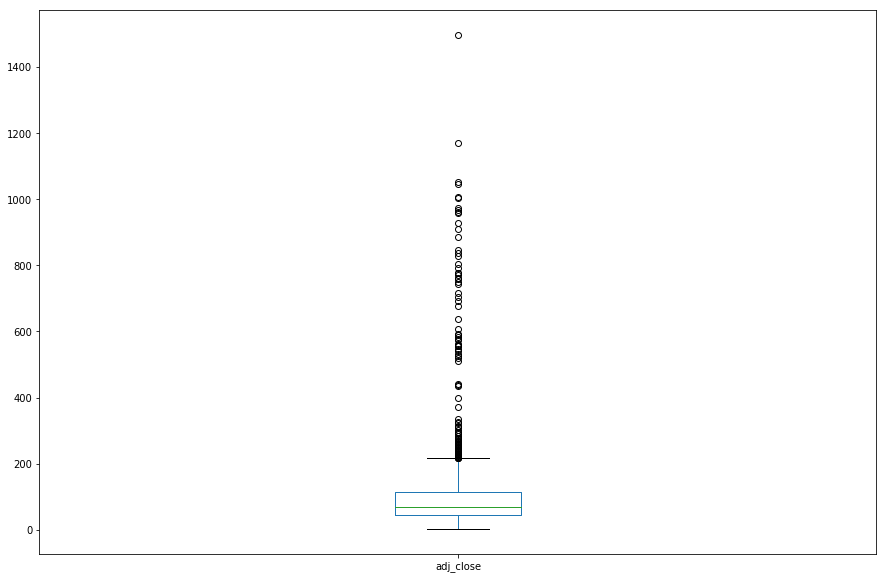

In [237]:
plt.figure(figsize=(15,10))
df_target['adj_close'].plot(kind='box')

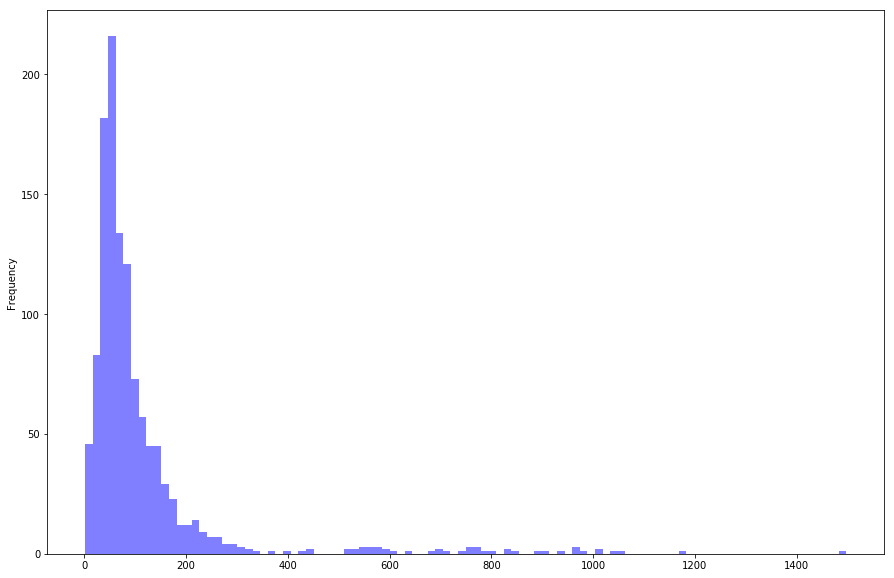

In [235]:
plt.figure(figsize=(15,10))
df_target['adj_close'].plot(kind='hist', color='b', alpha=0.5, bins=100)

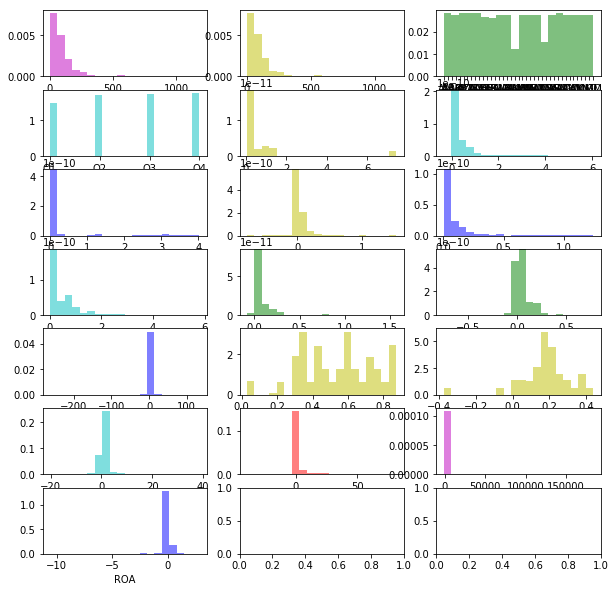

In [259]:
# #############################################################################
# Plot feature
fig, axs = plt.subplots(7, 3, figsize=(10, 10),sharex=False, sharey=False)
#fig2, axs2 = plt.subplots(5, 3, figsize=(8, 8),sharex=False, sharey=False)
r=0
c=0
plt.figure(figsize=(15,10))
#plt.figure(3)
feature_names = features.columns
for index, feature_name in enumerate(feature_names[:19]):
    color = np.random.choice(['r','b','y','g','c','m'])
    axs[r,c].hist(features.iloc[:, index], color=color, alpha=0.5, density=True, bins=20)
    axs[r,c].set_xlabel(feature_name)
    #axs[r,c].set_ylabel('Price')
    #axs2[r,c].scatter(data.data[:, index], data.target, color=color, alpha=0.5)
    #axs2[r,c].set_xlabel(feature_name)
    #axs2[r,c].set_ylabel('Price')
    c+=1
    if r > 8:
        r=0
    if c > 2:
        c=0
        r+=1
plt.subplots_adjust(hspace=0.46, wspace=0.29, top=0.94, right=0.95, bottom=0.07, left=0.07)

# ML

### Feature Importance

### Regression

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
# #############################################################################
# Fit regression model
X_train, X_test, y_train, y_test = train_test_split(features.iloc[:,13:18], df_target.iloc[:,2])
regr = LinearRegression()
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)
expected = y_test

ValueError: Found input variables with inconsistent numbers of samples: [724, 1180]

In [267]:
features.iloc[:,13:18].count()

GrossMarginPctTTM        724
OperatingMarginPctTTM    724
BasicEPSNetIncome        724
EPS                      724
PBV                      724
dtype: int64

In [269]:
df_target.iloc[:,2].count()

1180

### ML Performance

In [ ]:
# #############################################################################
# Regression model performance
print("RMS: {}".format(np.sqrt(np.mean((predicted - expected) ** 2))))
plt.figure(3)
corr_plot = sns.jointplot(expected, predicted, kind='reg', color='g', line_kws={"color":"b","alpha":0.7})
corr_plot.set_axis_labels('Expected', 'Predicted')

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: {}".format(metrics.mean_squared_error(expected, predicted)))
# Explained variance score: 1 is perfect prediction
print('Variance score: {}'.format(metrics.r2_score(expected, predicted)))

In [7]:
conn = engine.connect()
with conn:
    sql="Select date, adj_open, adj_close, symbol FROM historicalprice WHERE symbol= 'zts' ORDER BY date"
    df_target = pd.read_sql_query(sql, conn, index_col='date')

In [8]:
df_target

,adj_open,adj_close,symbol
date,,,
2013-06-30 00:00:00.000000,29.864926,29.855261,zts
2013-09-30 00:00:00.000000,30.123266,30.142638,zts
2013-12-31 00:00:00.000000,31.834287,31.727526,zts
2014-03-31 00:00:00.000000,28.278720,28.152259,zts
2014-06-30 00:00:00.000000,31.642756,31.467234,zts
2014-09-30 00:00:00.000000,36.204989,36.107269,zts
2014-12-31 00:00:00.000000,42.549858,42.128863,zts
2015-03-31 00:00:00.000000,45.867981,45.406947,zts
2015-06-30 00:00:00.000000,46.844339,47.384812,zts
